<a href="https://colab.research.google.com/github/rodgpt/MAR_FUTURA/blob/main/Boat%20Detector/Agile/RunModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RunModel

This notebook embeds all WAV files in a folder into a Hoplite DB, loads a previously-trained AGILE linear classifier, and writes an inference CSV.


In [1]:
# @title Imports
#!pip install git+https://github.com/google-research/perch-hoplite.git
#!pip install tensorflow
from etils import epath
import os

from perch_hoplite.agile import audio_loader
from perch_hoplite.agile import classifier
from perch_hoplite.agile import colab_utils
from perch_hoplite.agile import embed
from perch_hoplite.agile import source_info
from perch_hoplite.agile.classifier import LinearClassifier
from perch_hoplite.zoo import model_configs
from pathlib import Path
import shutil # Import shutil for file operations

/Users/rodrigo/Desktop/CODES/.venv311/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [5]:
# @title Configuration (COLAB ONLY) - Prefer embeddings cache, otherwise stage audio

import os
import subprocess
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# DRIVE PATHS (source of truth)
# -----------------------------
input_audio_dir_drive = "/content/drive/Shareddrives/Hydrophones/Matanzas/13-11-25/32"
classifier_path_drive = "/content/drive/Shareddrives/MAR FUTURA/Hydrophones/agile_classifier_v2.pt"
output_csv_drive = f"{input_audio_dir_drive}/inference.csv"

# Embeddings cache folder on Drive (you can rename, but keep it stable)
# Recommendation: encode model+sharding in the folder name to avoid accidental mismatch.
emb_cache_drive = f"{input_audio_dir_drive}/_agile_db" ##Check

# -----------------------------
# LOCAL PATHS (fast I/O)
# -----------------------------
run_root = "/content/run_matanzas_32"
input_audio_dir = f"{run_root}/audio"     # LOCAL staged audio (only used if cache missing)
db_path = f"{run_root}/db"                # LOCAL embeddings DB (restored or created)
classifier_path = f"{run_root}/model/agile_classifier_v2.pt"  # LOCAL model copy
output_csv_filepath = f"{run_root}/inference.csv"             # LOCAL output

# Create local directories
Path(db_path).mkdir(parents=True, exist_ok=True)
Path(classifier_path).parent.mkdir(parents=True, exist_ok=True)
Path(output_csv_filepath).parent.mkdir(parents=True, exist_ok=True)
# Ensure input_audio_dir exists even if not staging audio
Path(input_audio_dir).mkdir(parents=True, exist_ok=True)

# Ensure Drive cache directory exists
Path(emb_cache_drive).mkdir(parents=True, exist_ok=True)

def drive_cache_nonempty(cache_dir: str) -> bool:
    """True if cache_dir exists and contains at least one file."""
    if not os.path.isdir(cache_dir):
        return False
    for root, _, files in os.walk(cache_dir):
        if files:
            return True
    return False

# Flags used later (main run cell) to decide whether to sync DB back to Drive
embeddings_restored_from_drive = False

# -----------------------------
# STAGE DATA: Prefer embeddings cache -> local
# -----------------------------
if drive_cache_nonempty(emb_cache_drive):
    print("Found embeddings cache on Drive. Restoring embeddings DB to local disk...")
    # Clear local DB folder to avoid mixing old/new artifacts
    subprocess.run(["bash", "-lc", f"rm -rf '{db_path}'/*"], check=True)

    # Restore embeddings cache to local db_path
    subprocess.run([
        "rsync", "-a", "--info=progress2",
        emb_cache_drive.rstrip("/") + "/",
        db_path.rstrip("/") + "/",
    ], check=True)

    # IMPORTANT: do NOT stage audio in this branch
    print("Embeddings restored. Skipping audio staging.")
    staged_audio = False
    embeddings_restored_from_drive = True

else:
    print("No embeddings cache found on Drive. Staging WAV files to local disk so we can embed...")
    # Path(input_audio_dir).mkdir(parents=True, exist_ok=True) # This line is moved outside the if/else

    subprocess.run([
        "rsync", "-a", "--info=progress2", "--prune-empty-dirs",
        "--include=*/", "--include=*.wav", "--include=*.WAV",
        "--exclude=",
        input_audio_dir_drive.rstrip("/") + "/",
        input_audio_dir.rstrip("/") + "/",
    ], check=True)

    staged_audio = True

# Copy classifier weights locally (small optimization; not the main bottleneck)
print("Copying classifier checkpoint locally...")
subprocess.run(["cp", "-f", classifier_path_drive, classifier_path], check=True)

print("----- Paths-----")
print("input_audio_dir_drive:", input_audio_dir_drive)
print("emb_cache_drive:", emb_cache_drive)
print("input_audio_dir (LOCAL):", input_audio_dir)
print("db_path (LOCAL):", db_path)
print("classifier_path (LOCAL):", classifier_path)
print("output_csv_filepath (LOCAL):", output_csv_filepath)
print("output_csv_drive:", output_csv_drive)
print("staged_audio:", staged_audio)
print("embeddings_restored_from_drive:", embeddings_restored_from_drive)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found embeddings cache on Drive. Restoring embeddings DB to local disk...
Embeddings restored. Skipping audio staging.
Copying classifier checkpoint locally...
----- Paths-----
input_audio_dir_drive: /content/drive/Shareddrives/Hydrophones/Matanzas/13-11-25/32
emb_cache_drive: /content/drive/Shareddrives/Hydrophones/Matanzas/13-11-25/32/_agile_db
input_audio_dir (LOCAL): /content/run_matanzas_32/audio
db_path (LOCAL): /content/run_matanzas_32/db
classifier_path (LOCAL): /content/run_matanzas_32/model/agile_classifier_v2.pt
output_csv_filepath (LOCAL): /content/run_matanzas_32/inference.csv
output_csv_drive: /content/drive/Shareddrives/Hydrophones/Matanzas/13-11-25/32/inference.csv
staged_audio: False
embeddings_restored_from_drive: True


In [2]:
# @title Configuration (LOCAL ONLY)

# Run this cell only if you're running locally.

# -----------------------------
# PATHS (Local)
# -----------------------------

# Example (external drive / Drive File Stream / etc.)
# IMPORTANT: If this points to Google Drive / cloud-synced storage, local runs may be slow
# because files are fetched on-demand. Enable LOCAL_STAGING below to copy WAVs to your
# local SSD before embedding.
input_audio_dir = "/Volumes/Untitled"

# Embeddings DB folder
db_path = "/Volumes/Untitled/_agile_db"

# Output CSV path
output_csv_filepath = "/Volumes/Untitled/inference.csv"

# Trained classifier path
classifier_path = "agile_classifier_v2.pt"
#

# NOTE: After running either the Colab cell or the Local cell, always run the Common configuration cell below.


In [3]:
# @title Configuration (COMMON - ALWAYS RUN)

# Run this cell after you run either the Colab-only config cell OR the Local-only config cell.

# -----------------------------
# USER SETTINGS
# -----------------------------

dataset_name = 'RunDataset'
dataset_fileglob = '*.[wW][aA][vV]'

# Embedding model choice MUST match how you embedded when you trained the classifier.
model_choice = 'perch_8'

# Optional sharding (keep consistent with training if possible).
use_file_sharding = True
shard_length_in_seconds = 5

# Performance knobs
# - audio_worker_threads: parallel audio loading/processing
# - embed_batch_size: how many sources are queued per dispatch
# If you overload your machine, lower these.
audio_worker_threads = 8
embed_batch_size = 32

# Inference threshold. Higher => fewer detections.
logit_threshold = 2
labels = None

# File-level rule: require at least N consecutive windows above threshold
min_consecutive_segments = 2

# -----------------------------
# VALIDATE REQUIRED PATHS
# -----------------------------

_required = ['input_audio_dir', 'db_path', 'output_csv_filepath', 'classifier_path']
_missing = [k for k in _required if k not in globals() or not globals()[k]]
if _missing:
  raise RuntimeError(
      'Missing required path variables from the Colab-only or Local-only configuration cell: '
      + ', '.join(_missing)
  )

# Create directories (safe even if they already exist)
Path(output_csv_filepath).parent.mkdir(parents=True, exist_ok=True)
Path(db_path).mkdir(parents=True, exist_ok=True)

# -----------------------------
# CREATE CONFIGS
# -----------------------------

audio_glob = source_info.AudioSourceConfig(
    dataset_name=dataset_name,
    base_path=input_audio_dir,
    file_glob=dataset_fileglob,
    min_audio_len_s=1.0,
    target_sample_rate_hz=-2,
    shard_len_s=float(shard_length_in_seconds) if use_file_sharding else None,
)

configs = colab_utils.load_configs(
    source_info.AudioSources((audio_glob,)),
    db_path,
    model_config_key=model_choice,
    db_key='sqlite_usearch',
)

# Correcting the model handle for surfperch
if model_choice == 'surfperch':
  configs.model_config.model_config.tfhub_path = 'google/surfperch/1'

print('input_audio_dir:', input_audio_dir)
print('db_path:', configs.db_config.db_config.db_path)
print('classifier_path:', classifier_path)
print('output_csv_filepath:', output_csv_filepath)
print('audio_worker_threads:', audio_worker_threads)
print('embed_batch_size:', embed_batch_size)
print('logit_threshold:', logit_threshold)
print('min_consecutive_segments:', min_consecutive_segments)

if 'output_csv_drive' in globals() and output_csv_drive:
  print('output_csv_drive:', output_csv_drive)

input_audio_dir: /Volumes/Untitled
db_path: /Volumes/Untitled/_agile_db
classifier_path: agile_classifier_v2.pt
output_csv_filepath: /Volumes/Untitled/inference.csv
audio_worker_threads: 8
embed_batch_size: 32
logit_threshold: 2
min_consecutive_segments: 2


In [5]:
#@title Embed folder, load classifier, and run inference

import subprocess
from pathlib import Path

# Sanity checks: make sure input_audio_dir exists and contains WAVs.
# This prevents a silent 0it embed run when the folder is empty / not mounted / fileglob mismatch.

audio_root = Path(str(input_audio_dir))
print('input_audio_dir exists:', audio_root.exists(), 'is_dir:', audio_root.is_dir())

if not audio_root.exists() or not audio_root.is_dir():
    raise RuntimeError(f"input_audio_dir is not a readable directory: {input_audio_dir}")

try:
    wavs_lower = list(audio_root.rglob('*.wav'))
    wavs_upper = list(audio_root.rglob('*.WAV'))
    _wav_count = len(wavs_lower) + len(wavs_upper)
    _wav_examples = [str(p) for p in (wavs_lower[:3] + wavs_upper[:3])]
except Exception as e:
    raise RuntimeError(f"Failed while scanning for WAVs under input_audio_dir={input_audio_dir}: {e}")

print('WAV files found under input_audio_dir (recursive):', _wav_count)
if _wav_examples:
    print('WAV examples:', _wav_examples[:5])

# NOTE: perch-hoplite file_glob is applied relative to base_path. If your WAVs are in nested
# subfolders and you see 0 embeddings, you may need dataset_fileglob like '**/*.[wW][aA][vV]'.
if _wav_count == 0:
    raise RuntimeError(
        f"No WAV files found under input_audio_dir={input_audio_dir}. "
        "Check the path/mount, or update dataset_fileglob (e.g. '**/*.[wW][aA][vV]') if files are in subfolders."
    )

# 1) Connect/create DB (per configs from prior cell)
db = configs.db_config.load_db()
print('Initialized DB located at', configs.db_config.db_config.db_path)

# 2) Embed all files in the folder (skip if DB already non-empty)
print(f'Embedding dataset: {audio_glob.dataset_name}')
worker = embed.EmbedWorker(
    audio_sources=configs.audio_sources_config,
    db=db,
    model_config=configs.model_config,
    audio_worker_threads=int(audio_worker_threads),
)

existing = db.count_embeddings()
print('Existing embeddings in DB:', existing)

did_embed = False

if existing == 0:
    worker.process_all(
        target_dataset_name=audio_glob.dataset_name,
        batch_size=int(embed_batch_size),
    )
    did_embed = True
    print('Embedding complete, total embeddings:', db.count_embeddings())
else:
    print('Skipping embedding because DB is non-empty. Delete the db_path folder to force re-embed.')

# If running in Colab, persist the local DB back to Drive cache
# (Otherwise, /content is ephemeral and you will lose embeddings on runtime reset.)
if did_embed and 'emb_cache_drive' in globals() and emb_cache_drive:
    print('Syncing embeddings DB back to Drive cache:', emb_cache_drive)
    Path(emb_cache_drive).mkdir(parents=True, exist_ok=True)
    subprocess.run(
        [
            'rsync',
            '-a',
            '--progress',
            str(db_path).rstrip('/') + '/',
            str(emb_cache_drive).rstrip('/') + '/',
        ],
        check=True,
    )
    print('Done syncing embeddings cache to Drive.')

# 3) Load embedding model (needed for audio loader in some workflows; kept for parity)
db_model_config = db.get_metadata('model_config')
embed_config = db.get_metadata('audio_sources')
model_class = model_configs.get_model_class(db_model_config.model_key)
embedding_model = model_class.from_config(db_model_config.model_config)
audio_sources = source_info.AudioSources.from_config_dict(embed_config)
window_size_s = getattr(embedding_model, 'window_size_s', 5.0)
_ = audio_loader.make_filepath_loader(
    audio_sources=audio_sources,
    window_size_s=window_size_s,
    sample_rate_hz=embedding_model.sample_rate,
)

# 4) Load trained classifier and write inference CSV (window-level)
linear_classifier = LinearClassifier.load(classifier_path)

output_csv_all_logits_filepath = str(
    Path(output_csv_filepath).with_name(Path(output_csv_filepath).stem + '_all_logits.csv')
)

classifier.write_inference_csv(
    linear_classifier,
    db,
    output_csv_all_logits_filepath,
    -1.0e9,
    labels=labels,
)
print('Done. Wrote ALL window logits CSV:', output_csv_all_logits_filepath)

classifier.write_inference_csv(
    linear_classifier,
    db,
    output_csv_filepath,
    logit_threshold,
    labels=labels,
)
print('Done. Wrote FILTERED window-level CSV:', output_csv_filepath)

# 5) Post-process: per-file "boat" decision requires consecutive windows
import pandas as pd

score_col = None
file_level_csv = str(Path(output_csv_filepath).with_name(Path(output_csv_filepath).stem + '_filelevel.csv'))

df = pd.read_csv(output_csv_filepath)

if df.empty:
    print('Inference CSV was empty; skipping file-level post-processing.')
else:
    for c in ('logit', 'logits', 'score', 'prob', 'probability'):
        if c in df.columns:
            score_col = c
            break

    if score_col is None:
        raise RuntimeError('Could not find a score column in inference CSV. Expected one of: logit, logits, score, prob, probability')

    if 'label' in df.columns:
        df = df[df['label'].astype(str) == 'boat']

    if df.empty:
        print('No rows for label=boat in inference CSV; writing empty file-level CSV.')
        pd.DataFrame(columns=['filename', 'best_score', 'segments_over_threshold', 'longest_consecutive', 'is_boat']).to_csv(file_level_csv, index=False)
    else:
        df['window_start'] = pd.to_numeric(df.get('window_start'), errors='coerce')
        df[score_col] = pd.to_numeric(df[score_col], errors='coerce')
        df = df.dropna(subset=['filename', 'window_start', score_col]).copy()

        def longest_run(starts, step):
            starts = sorted(set(starts))
            if not starts:
                return 0
            eps = max(1e-6, abs(step) * 1e-6)
            best = 1
            cur = 1
            for i in range(1, len(starts)):
                if abs((starts[i] - starts[i - 1]) - step) <= eps:
                    cur += 1
                else:
                    best = max(best, cur)
                    cur = 1
            return max(best, cur)

        rows = []
        step = float(shard_length_in_seconds)
        thr = float(logit_threshold)
        min_cons = int(min_consecutive_segments)

        for fname, g in df.groupby('filename'):
            over = g[g[score_col] >= thr]
            starts_over = over['window_start'].dropna().tolist()
            lr = longest_run(starts_over, step)
            best = float(g[score_col].max()) if not g.empty else None
            cnt = int(len(starts_over))
            is_boat = lr >= min_cons
            rows.append({
                'filename': fname,
                'best_score': best,
                'segments_over_threshold': cnt,
                'longest_consecutive': lr,
                'is_boat': bool(is_boat),
            })

        out_df = pd.DataFrame(rows).sort_values(['is_boat', 'best_score'], ascending=[False, False])
        out_df.to_csv(file_level_csv, index=False)
        print('Wrote file-level CSV:', file_level_csv)

# 6) Optionally copy output CSV back to Drive (only if configured)
if 'output_csv_drive' in globals() and output_csv_drive:
    print('Copying inference CSV back to Drive...')
    subprocess.run(['cp', '-f', output_csv_filepath, output_csv_drive], check=True)
    print('Done. Wrote:', output_csv_drive)

input_audio_dir exists: True is_dir: True
WAV files found under input_audio_dir (recursive): 16337
WAV examples: ['/Volumes/Untitled/20251228_121600.WAV', '/Volumes/Untitled/20251228_115037.WAV', '/Volumes/Untitled/20251228_121419.WAV']
Initialized DB located at /Volumes/Untitled/_agile_db
Embedding dataset: RunDataset
Existing embeddings in DB: 0


  0%|          | 32/16337 [00:01<10:38, 25.54it/s]/Users/rodrigo/Desktop/CODES/.venv311/lib/python3.11/site-packages/perch_hoplite/audio_io.py:296: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audioread support is deprecated in librosa 0.10.0 and will be removed in version 1.0.
  sr = librosa.get_samplerate(filepath)
ERROR:root:Failed to parse audio file (/Volumes/Untitled/20251228_132000.WAV) : .
100%|█████████▉| 16331/16337 [11:40<00:00, 21.39it/s]/Users/rodrigo/Desktop/CODES/.venv311/lib/python3.11/site-packages/perch_hoplite/audio_io.py:296: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audioread support is deprecated in librosa 0.10.0 and will be removed in version 1.0.
  sr = librosa.get_samplerate(filepath)
ERROR:root:Failed to parse audio file (/Volumes/Untitled/20260120_043800.WAV) : .
100%|█████████▉| 16334/16337 [11:40<00:00, 22.29it/s]ERROR:root:Failed to parse audio file (/Volumes/Untitled/20260120_044000.WAV) : .
ERROR:root:Failed to parse

Embedding complete, total embeddings: 195971


192it [00:01, 190.27it/s]


Wrote 195971 detections to /Volumes/Untitled/inference_all_logits.csv
Done. Wrote ALL window logits CSV: /Volumes/Untitled/inference_all_logits.csv


192it [00:00, 2088.61it/s]


Wrote 320 detections to /Volumes/Untitled/inference.csv
Done. Wrote FILTERED window-level CSV: /Volumes/Untitled/inference.csv
Wrote file-level CSV: /Volumes/Untitled/inference_filelevel.csv


rows: 320
columns: ['idx', 'project', 'filename', 'window_start', 'window_end', 'label', 'logits']


/var/folders/98/p03nljld21n2xrkp6cmfsv6w0000gn/T/ipykernel_46272/843608019.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  detections_per_hour = plot_df['idx'].resample('1H').count()


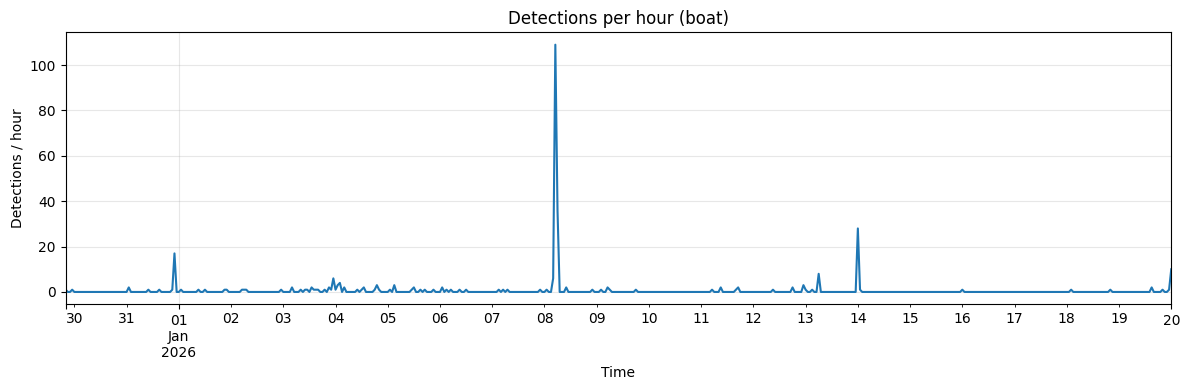

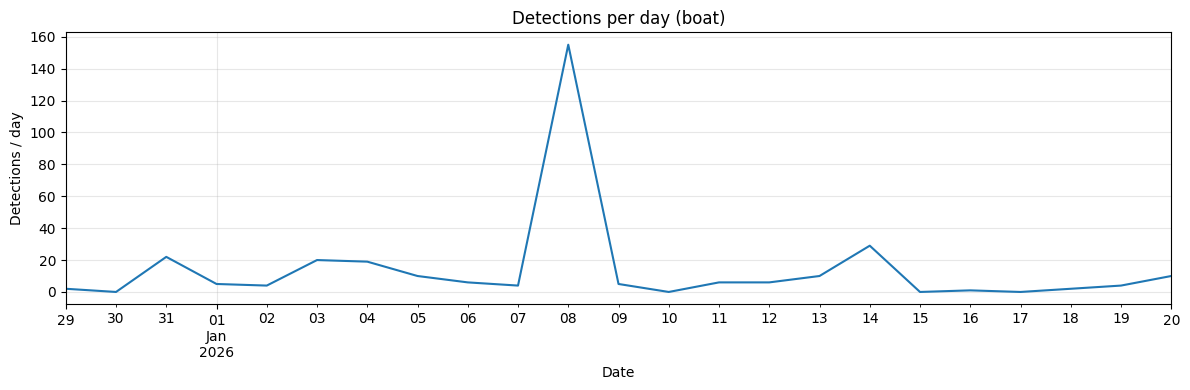

In [6]:
#@title Plot detections over time (detections/hour)

import re
import pandas as pd
import matplotlib.pyplot as plt

csv_path = output_csv_filepath

df = pd.read_csv(csv_path)
print('rows:', len(df))
print('columns:', list(df.columns))

# Optional: focus on one label (e.g. boat). Set to None to include all labels.
focus_label = 'boat'
if focus_label and 'label' in df.columns:
  df = df[df['label'] == focus_label]

# Parse datetime from filename like YYYYMMDD_HHMMSS(.WAV)
# Example: ZAPALLAR_20241122_143550_5sec.wav -> 20241122_143550
_dt_re = re.compile(r'(\d{8})_(\d{6})')

def extract_dt(fname: str):
  m = _dt_re.search(str(fname))
  if not m:
    return pd.NaT
  return pd.to_datetime(m.group(1) + m.group(2), format='%Y%m%d%H%M%S', errors='coerce')

df['file_dt'] = df['filename'].apply(extract_dt)

# If window_start exists, shift timestamp by that many seconds.
if 'window_start' in df.columns:
  df['window_start'] = pd.to_numeric(df['window_start'], errors='coerce')
  df['dt'] = df['file_dt'] + pd.to_timedelta(df['window_start'].fillna(0), unit='s')
else:
  df['dt'] = df['file_dt']

# Drop rows where we can't parse time
plot_df = df.dropna(subset=['dt']).copy()
if plot_df.empty:
  raise RuntimeError('No rows had a parseable datetime in filename. Adjust extract_dt() regex/format.')

plot_df = plot_df.set_index('dt').sort_index()

detections_per_hour = plot_df['idx'].resample('1H').count()

plt.figure(figsize=(12, 4))
detections_per_hour.plot()
plt.title(f'Detections per hour' + (f" ({focus_label})" if focus_label else ''))
plt.xlabel('Time')
plt.ylabel('Detections / hour')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: show daily totals too
show_daily = True

if show_daily:
  daily = plot_df['idx'].resample('1D').count()
  plt.figure(figsize=(12, 4))
  daily.plot()
  plt.title(f'Detections per day' + (f" ({focus_label})" if focus_label else ''))
  plt.xlabel('Date')
  plt.ylabel('Detections / day')
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()
